In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib matplotlib
import cmcrameri.cm as cmc  # Importing the cmcrameri colormaps

In [2]:
%run '../paper_figures/pf_data.py' 'little_dev_model/chem_model_far_rates.h5' 

<xarray.DataArray 'Diaspore_VF' (time: 141, x: 32, y: 1, z: 32)> Size: 1MB
array([[[[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
          1.00000000e-10, 1.00000000e-10, 1.00000000e-10]],

        [[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
          1.00000000e-10, 1.00000000e-10, 1.00000000e-10]],

        [[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
          1.00000000e-10, 1.00000000e-10, 1.00000000e-10]],

        ...,

        [[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
          1.00000000e-10, 1.00000000e-10, 1.00000000e-10]],

        [[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
          1.00000000e-10, 1.00000000e-10, 1.00000000e-10]],

        [[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
          1.00000000e-10, 1.00000000e-10, 1.00000000e-10]]],

...

       [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e

In [3]:
data['secondary_minerals_VF'].isel(time=-1).where(data['percentage_alteration'] > 0).max() / 7000

<xarray.DataArray 'secondary_minerals_VF' ()> Size: 8B
array(6.66209252e-05)

{'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
{'clays': ['Saponite_Mg', 'Illite_Mg', 'Chamosite-7A', 'Clinochlore-7A'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'serpentinites': ['Chrysotile', 'Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'hydroxides': ['Gibbsite', 'Diaspore']}


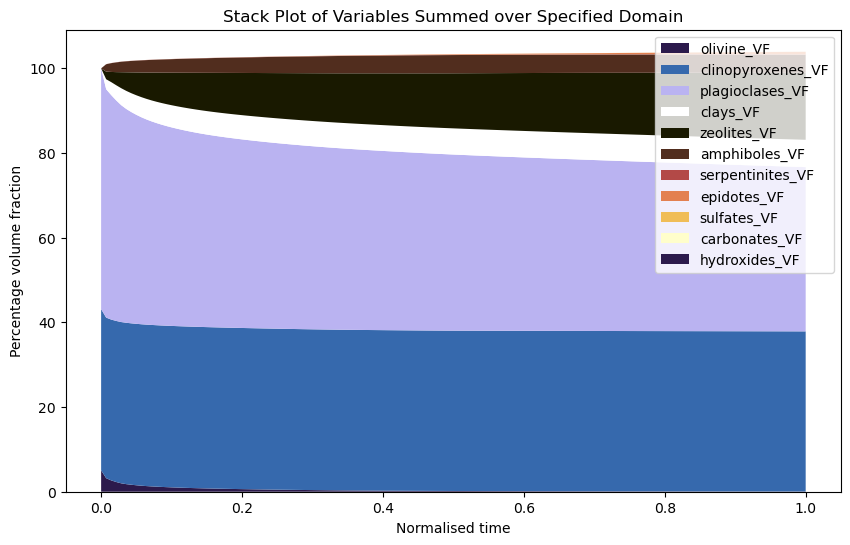

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import cmcrameri.cm as cm

# Select a sequential colormap from cmcrameri
# Define the number of groups (or layers) in the stack plot
# Extract colors from the colormap
colors_cool = cm.devon(np.linspace(0, 1, 4))  # Adjust 'num_groups' to the number of layers
colors_hot = cm.lajolla(np.linspace(0, 1, 6))
colors = np.vstack((colors_cool, colors_hot))
# Create a custom color cycler using the extracted colors
custom_cycler = cycler(color=colors)

def stack_plot(ax, ds, variable_groups, custom_cycler):
    variables = []
    for variable_group in variable_groups: 
        print(variable_group)
        for minerals in variable_group.keys():
            variables.extend([minerals + "_VF"])

    # Condition to sum over a part of the domain, based on another variable 'condition_var'
    # For example, let's sum where 'condition_var' is greater than a threshold value

    ax.set_prop_cycle(custom_cycler)
    
    threshold = 10
    condition = ds['percentage_alteration'].isel(time=-1) > threshold

    normalised = condition.sum(dim=['x', 'z', 'y']) * 0.9585
    # Calculate the sum of each variable over the specified condition
    sums = {}
    for var in variables:
        sums[var] = ds[var].where(condition).sum(dim=['x', 'z', 'y']) / normalised * 100 # Assuming 'x' and 'y' are spatial dimensions

    # Convert the sums into a stack plot
    # Assuming 'time' is the dimension you want to plot over
    stack_data = np.vstack([sums[var].values for var in variables])
    ax.stackplot(ds['time']/7000, stack_data, labels=variables)

    return ax


ds = data
# List of variables to include in the stack plot

fig, ax = plt.subplots(figsize=(10, 6))

stack_plot(ax, ds, [primary_mineral_groups, secondary_mineral_groups], custom_cycler)

# Create the stack plot
ax.set_xlabel('Normalised time')
ax.set_ylabel('Percentage volume fraction')
ax.legend()
plt.title('Stack Plot of Variables Summed over Specified Domain')
plt.show()


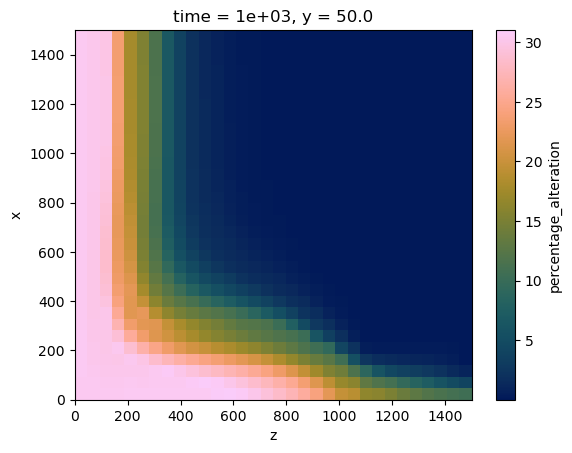

In [10]:
ds['percentage_alteration'].sel(time=1000).plot(cmap=cmc.batlow)

In [6]:
data['Porosity'].sel(time=7000).isel(x=0, z=0)

<xarray.DataArray 'Porosity' (y: 1)> Size: 8B
array([0.])
Coordinates:
    time     float64 8B 7e+03
    x        float64 8B 23.44
  * y        (y) float64 8B 50.0
    z        float64 8B 23.44
Attributes:
    units:    None